In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import osmnx as ox
import json


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pwd

'/home/cseadmin/dz/TrafficFlowModel/data_process/gis_pipeline'

In [1]:
DATA_PATH = "../../data/"
TAXI_DATA_PATH = "../../data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"

MIN_LAT = 22.5311
MAX_LAT = 22.5517
MIN_LNG = 114.0439
MAX_LNG = 114.0633

DATE_PREFIX = "2020-06-"
START_DAY = 1
END_DAY = 30

DOWNSAMPLING_INTERVAL = 10 #s
TRAJ_SPLIT_INTERVAL = 600
FLOW_AGG_INTERVAL_MINUTE = 5

def notify(msg):
    import datetime
    channel = "J0budaR2THarZw0OqS5O"
    notify_url = f"https://notify.run/{channel}"
    massage = f"{msg} | {str(datetime.datetime.now())}"
    os.system(f'curl {notify_url} -d "{massage}"')

In [50]:
a=np.array([0, 1], dtype=np.int16)
b=a.view(np.float16) # will always use same mem location (i.e. pointer &a==&b), and treat b as float array
print(a)
print(b)
b[0]=1.5
print(a)
print(b)
print("---")
a=np.array([0, 1], dtype=np.int16)
b=a.astype(np.float16, copy=False) # will still copy because int cannot be directly converted to float
print(a)
print(b)
b[0]=1.5
print(a)
print(b)
print("---")
a=np.array([0, 1], dtype=np.int16)
b=a.astype(np.int16, copy=False) # will not copy
print(a)
print(b)
b[0]=1.5
print(a)
print(b)

[0 1]
[0.e+00 6.e-08]
[15872     1]
[1.5e+00 6.0e-08]
---
[0 1]
[0. 1.]
[0 1]
[1.5 1. ]
---
[0 1]
[0 1]
[1 1]
[1 1]


geo

---

In [11]:
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

df_edges

,fid,u,v,geometry
0,0,39,105,"LINESTRING (114.04424 22.55066, 114.04424 22.5..."
1,1,129,36,"LINESTRING (114.04761 22.55094, 114.04768 22.5..."
2,2,36,68,"LINESTRING (114.04768 22.54928, 114.04667 22.5..."
3,3,68,10,"LINESTRING (114.04667 22.54928, 114.04665 22.5..."
4,4,39,10,"LINESTRING (114.04424 22.55066, 114.04665 22.5..."
...,...,...,...,...
487,487,79,45,"LINESTRING (114.06304 22.53372, 114.06297 22.5..."
488,488,73,79,"LINESTRING (114.06305 22.53176, 114.06304 22.5..."
489,489,102,79,"LINESTRING (114.06133 22.53171, 114.06304 22.5..."
490,490,102,73,"LINESTRING (114.06133 22.53171, 114.06305 22.5..."


In [4]:
df_geo=pd.DataFrame()

df_geo["geo_id"]=df_edges["fid"]
df_geo["type"]="LineString"
df_geo["coordinates"]=df_edges["geometry"].apply(lambda x: list(x.coords))

df_geo

,geo_id,type,coordinates
0,0,LineString,"[(114.04423924729905, 22.550663183705367), (11..."
1,1,LineString,"[(114.04761345337049, 22.550935297098224), (11..."
2,2,LineString,"[(114.04767694649549, 22.54928447584822), (114..."
3,3,LineString,"[(114.0466701269419, 22.54928447584822), (114...."
4,4,LineString,"[(114.04423924729905, 22.550663183705367), (11..."
...,...,...,...
487,487,LineString,"[(114.06303991233369, 22.533716708739618), (11..."
488,488,LineString,"[(114.06305083168648, 22.531762144591667), (11..."
489,489,LineString,"[(114.06132557394695, 22.531707547827757), (11..."
490,490,LineString,"[(114.06132557394695, 22.531707547827757), (11..."


In [5]:
df_geo.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.geo"), index=False)

rel

---

In [6]:
rel=[]
rel_id_counter=0

u_dict={}

for _, row in df_edges.iterrows():
    if row["u"] not in u_dict.keys():
        u_dict[row["u"]]=[]
    u_dict[row["u"]].append(row["fid"])
    
for _, row in df_edges.iterrows():
    for adj_fid in u_dict[row["v"]]:
        rel.append([rel_id_counter, "geo", row["fid"], adj_fid])
        rel_id_counter+=1

df_rel=pd.DataFrame(rel, columns=["rel_id", "type", "origin_id", "destination_id"])

df_rel

,rel_id,type,origin_id,destination_id
0,0,geo,0,70
1,1,geo,0,246
2,2,geo,0,252
3,3,geo,1,2
4,4,geo,1,63
...,...,...,...,...
1689,1689,geo,490,244
1690,1690,geo,490,488
1691,1691,geo,491,245
1692,1692,geo,491,489


In [8]:
df_rel.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.rel"), index=False)

dyna

---

In [4]:
df_fmm_res=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "mr.txt"), sep=";").set_index("id").dropna()
df_fmm_data=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "gps.csv"), sep=";", parse_dates=["time"])

df_fmm_res # 1828761 -> 575713 -> 357217
df_fmm_data # 23599651 -> 40249046 -> 39088814

,opath,cpath,mgeom
id,,,
10941,"200,200,200,201","200,427,201","LINESTRING(114.0501629 22.5317252362,114.05005..."
64074,"188,188",188,"LINESTRING(114.044444296 22.5370763192,114.044..."
21882,"250,0","250,0","LINESTRING(114.044239247 22.5506631837,114.044..."
1563,"489,489",489,"LINESTRING(114.061869579 22.532345108,114.0622..."
98438,"485,209,210,211,444,443","485,484,478,229,476,209,210,211,202,445,444,443","LINESTRING(114.062352687 22.5336789491,114.062..."
...,...,...,...
1810066,"131,159,188,197,197","131,159,188,189,197","LINESTRING(114.044353627 22.5444977666,114.044..."
1810067,"197,198","197,198","LINESTRING(114.044607383 22.5321587318,114.044..."
1810068,"0,131,131,189","0,70,94,131,159,188,189","LINESTRING(114.044239247 22.5492782593,114.044..."


,id,x,y,time,speed
0,0,114.050660,22.551142,2020-06-01 10:07:21,5
1,0,114.050690,22.551117,2020-06-01 10:08:36,9
2,0,114.052180,22.551144,2020-06-01 10:08:51,55
3,0,114.056800,22.551168,2020-06-01 10:09:21,40
4,0,114.057950,22.546215,2020-06-01 10:11:22,23
...,...,...,...,...,...
21320436,1810919,114.057686,22.531790,2020-06-30 09:13:41,30
21320437,1810920,114.043950,22.531195,2020-06-30 15:13:24,58
21320438,1810920,114.051240,22.531390,2020-06-30 15:14:14,41
21320439,1810920,114.054790,22.531458,2020-06-30 15:14:44,57


In [5]:
def convert_path(row):
    row["opath"]=np.array(row["opath"].split(","), dtype=np.int16)
    row["cpath"]=np.array(row["cpath"].split(","), dtype=np.int16)
    row["cpath_len"]=len(row["cpath"])
    
    return row

df_fmm_res=df_fmm_res.apply(convert_path, axis=1)

df_fmm_res

,opath,cpath,mgeom,cpath_len
id,,,,
10941,"[200, 200, 200, 201]","[200, 427, 201]","LINESTRING(114.0501629 22.5317252362,114.05005...",3
64074,"[188, 188]",[188],"LINESTRING(114.044444296 22.5370763192,114.044...",1
21882,"[250, 0]","[250, 0]","LINESTRING(114.044239247 22.5506631837,114.044...",2
1563,"[489, 489]",[489],"LINESTRING(114.061869579 22.532345108,114.0622...",1
98438,"[485, 209, 210, 211, 444, 443]","[485, 484, 478, 229, 476, 209, 210, 211, 202, ...","LINESTRING(114.062352687 22.5336789491,114.062...",12
...,...,...,...,...
1810066,"[131, 159, 188, 197, 197]","[131, 159, 188, 189, 197]","LINESTRING(114.044353627 22.5444977666,114.044...",5
1810067,"[197, 198]","[197, 198]","LINESTRING(114.044607383 22.5321587318,114.044...",2
1810068,"[0, 131, 131, 189]","[0, 70, 94, 131, 159, 188, 189]","LINESTRING(114.044239247 22.5492782593,114.044...",7


In [10]:
df_fmm_res.loc[df_fmm_res.cpath_len==1]

,opath,cpath,mgeom,cpath_len
id,,,,
31260,"[490, 490]",[490],"LINESTRING(114.062315041 22.5317388601,114.062...",1
17199,"[242, 242]",[242],"LINESTRING(114.063050832 22.5317621446,114.063...",1
81263,"[81, 81]",[81],"LINESTRING(114.051192347 22.5405205358,114.051...",1
59390,"[267, 267]",[267],"LINESTRING(114.060274555 22.5485917485,114.060...",1
39078,"[18, 18]",[18],"LINESTRING(114.062420814 22.5513914653,114.062...",1
...,...,...,...,...
2928905,"[413, 413]",[413],"LINESTRING(114.050418595 22.5374123603,114.050...",1
2928906,"[408, 408, 408]",[408],"LINESTRING(114.049210292 22.5373952134,114.048...",1
2925388,"[14, 14]",[14],"LINESTRING(114.058947345 22.5503945492,114.058...",1


array(['2020-06-01T19:00:07.000000000', '2020-06-01T19:01:47.000000000',
       '2020-06-01T19:05:17.000000000', '2020-06-01T19:06:06.000000000',
       '2020-06-01T19:08:07.000000000', '2020-06-01T19:09:47.000000000',
       '2020-06-01T19:10:47.000000000', '2020-06-01T19:12:06.000000000',
       '2020-06-01T19:13:59.000000000', '2020-06-01T19:14:29.000000000',
       '2020-06-01T19:15:07.000000000', '2020-06-01T19:15:46.000000000',
       '2020-06-01T19:17:10.000000000', '2020-06-01T19:22:26.000000000',
       '2020-06-01T19:23:36.000000000', '2020-06-01T19:24:26.000000000',
       '2020-06-01T19:34:01.000000000'], dtype='datetime64[ns]')

array([444, 456, 474, 473, 234, 459, 451, 425, 168, 328, 326,  80,  81,
        81, 327, 327,  81], dtype=int16)

array([444, 198, 199, 448, 457, 456, 455, 474, 473, 224, 234, 480, 470,
       459, 458, 451, 449, 180, 425, 168, 410, 328, 327, 326,  80,  81,
       327,  81, 327,  81], dtype=int16)

<AxesSubplot:>

<AxesSubplot:>

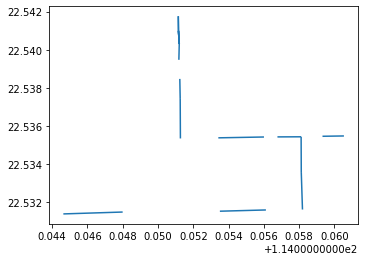

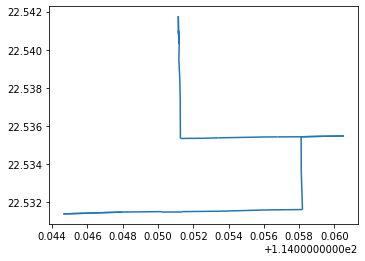

In [6]:
# traj_id=1577

# time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
# opath_list=df_fmm_res.loc[traj_id, "opath"]
# cpath_list=df_fmm_res.loc[traj_id, "cpath"]

# time_list
# opath_list
# cpath_list

# df_edges.loc[opath_list].plot()
# df_edges.loc[cpath_list].plot()

In [7]:
# del_indexes=[]
# for i in range(len(time_list)-1):
#     if opath_list[i]==opath_list[i+1]:
#         del_indexes.append(i+1)

# opath_list=np.delete(opath_list, del_indexes)
# time_list=np.delete(time_list, del_indexes)

# assert(len(opath_list)==len(time_list))
# assert(opath_list[-1]==cpath_list[-1])

# time_list
# opath_list
# cpath_list

array(['2020-06-01T19:00:07.000000000', '2020-06-01T19:01:47.000000000',
       '2020-06-01T19:05:17.000000000', '2020-06-01T19:06:06.000000000',
       '2020-06-01T19:08:07.000000000', '2020-06-01T19:09:47.000000000',
       '2020-06-01T19:10:47.000000000', '2020-06-01T19:12:06.000000000',
       '2020-06-01T19:13:59.000000000', '2020-06-01T19:14:29.000000000',
       '2020-06-01T19:15:07.000000000', '2020-06-01T19:15:46.000000000',
       '2020-06-01T19:17:10.000000000', '2020-06-01T19:23:36.000000000',
       '2020-06-01T19:34:01.000000000'], dtype='datetime64[ns]')

array([444, 456, 474, 473, 234, 459, 451, 425, 168, 328, 326,  80,  81,
       327,  81], dtype=int16)

array([444, 198, 199, 448, 457, 456, 455, 474, 473, 224, 234, 480, 470,
       459, 458, 451, 449, 180, 425, 168, 410, 328, 327, 326,  80,  81,
       327,  81, 327,  81], dtype=int16)

In [13]:
# i=0
# j=0
# recovered_time_list=[]

# while True:
#     if i>len(opath_list)-1:
#         break
#     if opath_list[i]==cpath_list[j]:
#         recovered_time_list.append(time_list[i])
#         i+=1
#         j+=1
#     else:
#         length=0
#         while opath_list[i]!=cpath_list[j]:
#             j+=1
#             length+=1
#         recovered_time_list.extend(gen_time_seq(time_list[i-1], time_list[i], length))
# cpath_list=cpath_list[:j] # fmm bug: trailing
            
# assert(len(recovered_time_list)==len(cpath_list))

# list(zip(cpath_list, recovered_time_list))

[(444, numpy.datetime64('2020-06-01T19:00:07.000000000')),
 (198, numpy.datetime64('2020-06-01T19:00:27.000000000')),
 (199, numpy.datetime64('2020-06-01T19:00:47.000000000')),
 (448, numpy.datetime64('2020-06-01T19:01:07.000000000')),
 (457, numpy.datetime64('2020-06-01T19:01:27.000000000')),
 (456, numpy.datetime64('2020-06-01T19:01:47.000000000')),
 (455, numpy.datetime64('2020-06-01T19:03:32.000000000')),
 (474, numpy.datetime64('2020-06-01T19:05:17.000000000')),
 (473, numpy.datetime64('2020-06-01T19:06:06.000000000')),
 (224, numpy.datetime64('2020-06-01T19:07:06.500000000')),
 (234, numpy.datetime64('2020-06-01T19:08:07.000000000')),
 (480, numpy.datetime64('2020-06-01T19:08:40.333333333')),
 (470, numpy.datetime64('2020-06-01T19:09:13.666666666')),
 (459, numpy.datetime64('2020-06-01T19:09:47.000000000')),
 (458, numpy.datetime64('2020-06-01T19:10:17.000000000')),
 (451, numpy.datetime64('2020-06-01T19:10:47.000000000')),
 (449, numpy.datetime64('2020-06-01T19:11:13.333333333')

In [7]:
# https://stackoverflow.com/questions/35599607/average-date-array-calculation
# https://stackoverflow.com/questions/60949296/how-to-calculate-averages-of-datetime64ns-numpy-ndarray

def gen_time_seq(start_time, end_time, length):
    assert(end_time>start_time)
    
    start_time=start_time.view(np.int64)
    end_time=end_time.view(np.int64)
    
    seq=[]
    step=(end_time-start_time)//(length+1)
    for i in range(length):
        seq.append(start_time+step*(i+1))
    
    return list(np.array(seq, dtype="datetime64[ns]"))

def gen_speed_seq(start_speed, end_speed, length, method):
    speed_interpo_list=[start_speed]
    speed_interpo_list.extend([None]*length)
    speed_interpo_list.append(end_speed)
    
    speed_interpo_list=pd.Series(speed_interpo_list).interpolate(method)
    
    return list(speed_interpo_list[1:-1])

gen_speed_seq(10, 20, 4, "linear")
gen_speed_seq(10, 20, 4, "nearest")

[12.0, 14.0, 16.0, 18.0]

[10.0, 10.0, 20.0, 20.0]

In [ ]:
notify(f"Start {FLOW_AGG_INTERVAL_MINUTE}min recovered dyna.")

N=len(df_edges)

dyna_file=open(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"), "w")
write_length=dyna_file.write("dyna_id,type,time,entity_id,flow,speed\n") # disable printing return value

flow_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)
speed_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int32)
# count_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)

for traj_id in tqdm(df_fmm_res.index):
    time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
    speed_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["speed"].values
    opath_list=df_fmm_res.loc[traj_id, "opath"]
    cpath_list=df_fmm_res.loc[traj_id, "cpath"]
    
    if len(cpath_list)<2:
        continue
    
    # drop duplicates
    del_indexes=[]
    for i in range(len(time_list)-1):
        if opath_list[i]==opath_list[i+1]:
            del_indexes.append(i+1)

    opath_list=np.delete(opath_list, del_indexes)
    time_list=np.delete(time_list, del_indexes)
    speed_list=np.delete(speed_list, del_indexes)

    assert(len(opath_list)==len(time_list) and len(opath_list)==len(speed_list))
    assert(opath_list[-1]==cpath_list[-1])
    
    # generate recovered time & speed
    i=0
    j=0
    recovered_time_list=[]
    recovered_speed_list=[]

    while True:
        if i>len(opath_list)-1:
            break
        if opath_list[i]==cpath_list[j]:
            recovered_time_list.append(time_list[i])
            recovered_speed_list.append(speed_list[i])
            i+=1
            j+=1
        else:
            length=0
            while opath_list[i]!=cpath_list[j]:
                j+=1
                length+=1
            recovered_time_list.extend(gen_time_seq(time_list[i-1], time_list[i], length))
            recovered_speed_list.extend(gen_speed_seq(speed_list[i-1], speed_list[i], length, "linear"))
    cpath_list=cpath_list[:j] # fmm bug: trailing
    assert(len(recovered_time_list)==len(cpath_list))
    assert(len(recovered_speed_list)==len(cpath_list))
    
    for i in range(len(cpath_list)):
        time_i=pd.to_datetime(recovered_time_list[i])
        day=time_i.day
        mins=time_i.hour*60+time_i.minute
        
        flow_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][cpath_list[i]]+=1
        speed_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][cpath_list[i]]+=recovered_speed_list[i]
#         if recovered_speed_list[i]!=0: # 0 means missing data
#             count_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][cpath_list[i]]+=1

# avg speed
speed_matrix=speed_matrix/flow_matrix
avg_speed=np.nanmean(speed_matrix)
np.nan_to_num(speed_matrix, nan=avg_speed, posinf=0.0, copy=False)

dyna_id_counter=0
for day in tqdm(range(flow_matrix.shape[0])):
    if day==18 or day==19:
        continue
    for interval in range(flow_matrix.shape[1]):
        for road in range(flow_matrix.shape[2]):
            write_length=dyna_file.write(f"{dyna_id_counter},"+
                    "state,"+
                    f"{DATE_PREFIX}{str(day+START_DAY).zfill(2)}T{str(interval*FLOW_AGG_INTERVAL_MINUTE//60).zfill(2)}:{str((interval%(60//FLOW_AGG_INTERVAL_MINUTE))*FLOW_AGG_INTERVAL_MINUTE).zfill(2)}:00Z,"+
                    f"{road},"+
                    f"{flow_matrix[day][interval][road]},"+
                    f"{speed_matrix[day][interval][road]}\n")
            dyna_id_counter+=1
            
dyna_file.close()

# delete date 0619, 0620
flow_matrix_no1920=np.delete(flow_matrix, [18, 19], axis=0)
speed_matrix_no1920=np.delete(speed_matrix, [18, 19], axis=0)

np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_flow.npy"), flow_matrix_no1920)
np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_speed.npy"), speed_matrix_no1920)

notify(f"Finish {FLOW_AGG_INTERVAL_MINUTE}min recovered dyna.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    57  100     2  100    55      3     94 --:--:-- --:--:-- --:--:--    98


ok

  0%|          | 5254/1810865 [03:47<21:14:34, 23.61it/s]

In [12]:
avg_speed
np.nanmean(speed_matrix)

29.339837995376357

29.339837995376364

In [ ]:
# no recovery

# N=len(df_edges)

# dyna_file=open(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min.dyna"), "w")
# write_length=dyna_file.write("dyna_id,type,time,entity_id,flow\n") # disable printing return value

# flow_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)

# for traj_id in tqdm(df_fmm_res.index):
#     time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
#     road_list=df_fmm_res.loc[traj_id, "opath"]
    
#     assert(len(time_list)==len(road_list))
    
#     for i in range(len(road_list)):
#         time_i=pd.to_datetime(time_list[i])
#         day=time_i.day
#         mins=time_i.hour*60+time_i.minute
        
#         flow_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][road_list[i]]+=1
        
# dyna_id_counter=0
# for day in tqdm(range(flow_matrix.shape[0])):
#     if day==18 or day==19:
#         continue
#     for interval in range(flow_matrix.shape[1]):
#         for road in range(flow_matrix.shape[2]):
#             write_length=dyna_file.write(f"{dyna_id_counter},"+
#                     "state,"+
#                     f"{DATE_PREFIX}{str(day+START_DAY).zfill(2)}T{str(interval*FLOW_AGG_INTERVAL_MINUTE//60).zfill(2)}:{str((interval%(60//FLOW_AGG_INTERVAL_MINUTE))*FLOW_AGG_INTERVAL_MINUTE).zfill(2)}:00Z,"+
#                     f"{road},"+
#                     f"{flow_matrix[day][interval][road]}\n")
#             dyna_id_counter+=1
            
# dyna_file.close()

# # delete date 0619, 0620
# flow_matrix_no1920=np.delete(flow_matrix, [18, 19], axis=0)

# np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min.npy"), flow_matrix_no1920)

  0%|          | 1112/1996483 [00:21<10:47:47, 51.34it/s]

In [13]:
df_dyna_all=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"))

df_dyna_all=df_dyna_all.sort_values("flow", ascending=False)
df_dyna_all[:100]

,dyna_id,type,time,entity_id,flow,speed
615444,615444,state,2020-06-05T08:10:00Z,444,140,23.892857
51370,51370,state,2020-06-01T08:40:00Z,202,137,35.072993
617662,617662,state,2020-06-05T08:35:00Z,202,135,30.525926
618154,618154,state,2020-06-05T08:40:00Z,202,134,30.843284
51612,51612,state,2020-06-01T08:40:00Z,444,133,29.541353
...,...,...,...,...,...,...
3024034,3024034,state,2020-06-24T08:10:00Z,202,107,36.401869
2886274,2886274,state,2020-06-23T08:50:00Z,202,107,36.102804
2888741,2888741,state,2020-06-23T09:15:00Z,209,107,31.542056
2885040,2885040,state,2020-06-23T08:35:00Z,444,107,26.514019


In [14]:
df_dyna_all.loc[df_dyna_all["speed"]!=0, "speed"].describe() # 0 -> mean

count    3.967488e+06
mean     2.933394e+01
std      9.744942e+00
min      1.000000e+00
25%      2.325000e+01
50%      2.933984e+01
75%      3.483333e+01
max      6.000000e+01
Name: speed, dtype: float64

In [15]:
df_dyna_all.loc[df_dyna_all.flow>0, "flow"].describe()

count    3.106191e+06
mean     8.312157e+00
std      8.581717e+00
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.100000e+01
max      1.400000e+02
Name: flow, dtype: float64

In [16]:
df_dyna_all.flow.sum()

25819148

In [12]:
df_temp=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_no23.dyna"))

df_temp.sort_values("flow", ascending=False)[:100]
df_temp.loc[df_temp.flow>0, "flow"].describe()

,dyna_id,type,time,entity_id,flow,speed
591828,615444,state,2020-06-05T08:10:00Z,444,141,23.308943
51370,51370,state,2020-06-01T08:40:00Z,202,138,36.775000
594538,618154,state,2020-06-05T08:40:00Z,202,135,31.829268
594046,617662,state,2020-06-05T08:35:00Z,202,134,31.636364
51612,51612,state,2020-06-01T08:40:00Z,444,132,29.846847
...,...,...,...,...,...,...
1947780,2030436,state,2020-06-15T07:50:00Z,444,108,30.957895
1273248,1326384,state,2020-06-10T08:35:00Z,444,108,28.142857
2628966,2741142,state,2020-06-22T08:15:00Z,210,108,35.377778
2221098,2315562,state,2020-06-17T08:10:00Z,210,108,41.611111


count    3.019963e+06
mean     8.506856e+00
std      8.686332e+00
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.200000e+01
max      1.410000e+02
Name: flow, dtype: float64

In [13]:
df_temp.flow.sum()

25690390

/home/cseadmin/dz/anaconda3/envs/dz/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='flow', ylabel='Density'>

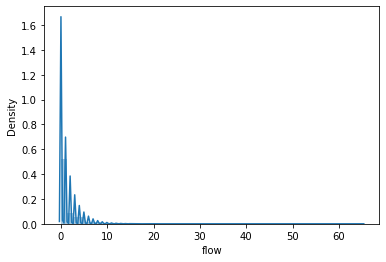

In [11]:
import seaborn as sns
sns.distplot(df_dyna_all["flow"])

In [46]:
# df_dyna=df_dyna_all.loc[(df_dyna_all["time"]<"2020-06-19T00:00:00Z") | (df_dyna_all["time"]>="2020-06-21T00:00:00Z")]

# df_dyna
# df_dyna.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.dyna"), index=False)

,dyna_id,type,time,entity_id,flow
0,0,state,2020-06-01T00:00:00Z,0,24
1,1,state,2020-06-01T00:00:00Z,1,3
2,2,state,2020-06-01T00:00:00Z,2,0
3,3,state,2020-06-01T00:00:00Z,3,0
4,4,state,2020-06-01T00:00:00Z,4,27
...,...,...,...,...,...
1416955,1416955,state,2020-06-30T23:45:00Z,487,0
1416956,1416956,state,2020-06-30T23:45:00Z,488,0
1416957,1416957,state,2020-06-30T23:45:00Z,489,0
1416958,1416958,state,2020-06-30T23:45:00Z,490,0


config

---

In [17]:
import json

config={}

config["geo"]={}
config["geo"]["including_types"]=["LineString"]
config["geo"]["LineString"]={}

config["rel"]={}
config["rel"]["including_types"]=["geo"]
config["rel"]["geo"]={}

config["dyna"]={}
config["dyna"]["including_types"]=["state"]
config["dyna"]["state"]={"entity_id": "geo_id", "flow": "num"}

config["info"]={}
config["info"]["data_files"]=f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered"
config["info"]["geo_file"]=DATASET
config["info"]["rel_file"]=DATASET
config["info"]["data_col"]=["flow"]
config["info"]["output_dim"]=1
# config["info"]["weight_col"]="link_weight"
config["info"]["time_intervals"]=60*FLOW_AGG_INTERVAL_MINUTE
config["info"]["init_weight_inf_or_zero"]="zero" # adj matrix not connected: 0 (inf: infinity)
config["info"]["set_weight_link_or_dist"]="link" # adj matrix 01 (dist: use weight)
config["info"]["calculate_weight_adj"]=False
# config["info"]["weight_adj_epsilon"]=0.1 # disabled when the above is false

json.dump(config, open(os.path.join(DATA_PATH, DATASET, "config.json"), "w", encoding="utf-8"), ensure_ascii=False)
config

{'geo': {'including_types': ['LineString'], 'LineString': {}},
 'rel': {'including_types': ['geo'], 'geo': {}},
 'dyna': {'including_types': ['state'],
  'state': {'entity_id': 'geo_id', 'flow': 'num'}},
 'info': {'data_files': 'sz_taxi_202006_5min_recovered',
  'geo_file': 'sz_taxi_202006',
  'rel_file': 'sz_taxi_202006',
  'data_col': ['flow'],
  'output_dim': 1,
  'time_intervals': 300,
  'init_weight_inf_or_zero': 'zero',
  'set_weight_link_or_dist': 'link',
  'calculate_weight_adj': False}}

dl_traffic

must run in python 3.7

---

In [2]:
import pandas as pd

df_dyna=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"), parse_dates=["time"])

df_dyna

,dyna_id,type,time,entity_id,flow,speed
0,0,state,2020-06-01 00:00:00+00:00,0,17,41.235294
1,1,state,2020-06-01 00:00:00+00:00,1,2,42.000000
2,2,state,2020-06-01 00:00:00+00:00,2,1,34.000000
3,3,state,2020-06-01 00:00:00+00:00,3,0,29.339838
4,4,state,2020-06-01 00:00:00+00:00,4,14,38.928571
...,...,...,...,...,...,...
3967483,3967483,state,2020-06-30 23:55:00+00:00,487,0,29.339838
3967484,3967484,state,2020-06-30 23:55:00+00:00,488,0,29.339838
3967485,3967485,state,2020-06-30 23:55:00+00:00,489,0,29.339838
3967486,3967486,state,2020-06-30 23:55:00+00:00,490,0,29.339838


In [4]:
df_dlt=pd.DataFrame(columns=range(492))

for row in df_dyna.itertuples():
    df_dlt.loc[row[3], row[4]]=row[5]
    
df_dlt

,0,1,2,3,4,5,6,7,8,9,...,482,483,484,485,486,487,488,489,490,491
2020-06-01 00:00:00+00:00,18,2,1,0,13,5,1,5,5,12,...,6,0,5,3,6,18,10,4,10,6
2020-06-01 00:05:00+00:00,14,0,0,1,11,0,0,3,8,4,...,5,0,5,6,5,20,18,6,12,8
2020-06-01 00:10:00+00:00,20,2,0,0,18,6,0,7,8,12,...,5,0,1,0,3,22,17,13,10,8
2020-06-01 00:15:00+00:00,19,0,1,1,21,5,0,5,7,5,...,2,1,3,3,2,16,4,10,9,12
2020-06-01 00:20:00+00:00,14,2,0,1,16,9,1,10,5,5,...,4,1,7,8,4,16,14,9,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 23:35:00+00:00,0,0,0,0,0,1,0,1,1,0,...,1,0,0,1,1,3,3,0,0,0
2020-06-30 23:40:00+00:00,0,0,1,1,1,0,0,0,1,0,...,0,0,1,0,0,2,1,1,0,1
2020-06-30 23:45:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-30 23:50:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_dlt.loc["2020-06-01 23:00:00":"2020-06-01 23:55:00"].mean(axis=1)

2020-06-01 23:00:00+00:00    1.469512
2020-06-01 23:05:00+00:00    1.430894
2020-06-01 23:10:00+00:00    1.319106
2020-06-01 23:15:00+00:00    1.063008
2020-06-01 23:20:00+00:00    1.126016
2020-06-01 23:25:00+00:00    1.063008
2020-06-01 23:30:00+00:00    0.967480
2020-06-01 23:35:00+00:00    0.945122
2020-06-01 23:40:00+00:00    0.654472
2020-06-01 23:45:00+00:00    0.439024
2020-06-01 23:50:00+00:00    0.186992
2020-06-01 23:55:00+00:00    0.573171
dtype: float64

In [6]:
df_dlt.loc["2020-06-14 23:00:00":"2020-06-14 23:55:00"].mean(axis=1)

2020-06-14 23:00:00+00:00    0.943089
2020-06-14 23:05:00+00:00    0.967480
2020-06-14 23:10:00+00:00    1.018293
2020-06-14 23:15:00+00:00    0.770325
2020-06-14 23:20:00+00:00    0.729675
2020-06-14 23:25:00+00:00    0.776423
2020-06-14 23:30:00+00:00    0.719512
2020-06-14 23:35:00+00:00    0.741870
2020-06-14 23:40:00+00:00    0.333333
2020-06-14 23:45:00+00:00    0.231707
2020-06-14 23:50:00+00:00    0.186992
2020-06-14 23:55:00+00:00    0.680894
dtype: float64

In [7]:
df_dlt.loc["2020-06-15 00:00:00":"2020-06-15 00:55:00"].mean(axis=1)

2020-06-15 00:00:00+00:00    3.087398
2020-06-15 00:05:00+00:00    2.109756
2020-06-15 00:10:00+00:00    1.611789
2020-06-15 00:15:00+00:00    1.573171
2020-06-15 00:20:00+00:00    1.587398
2020-06-15 00:25:00+00:00    1.886179
2020-06-15 00:30:00+00:00    1.837398
2020-06-15 00:35:00+00:00    1.699187
2020-06-15 00:40:00+00:00    1.754065
2020-06-15 00:45:00+00:00    1.583333
2020-06-15 00:50:00+00:00    1.426829
2020-06-15 00:55:00+00:00    1.605691
dtype: float64

In [8]:
df_dlt.loc["2020-06-15 01:00:00":"2020-06-15 01:55:00"].mean(axis=1)

2020-06-15 01:00:00+00:00    1.691057
2020-06-15 01:05:00+00:00    1.717480
2020-06-15 01:10:00+00:00    1.298780
2020-06-15 01:15:00+00:00    1.349593
2020-06-15 01:20:00+00:00    1.790650
2020-06-15 01:25:00+00:00    1.457317
2020-06-15 01:30:00+00:00    1.410569
2020-06-15 01:35:00+00:00    1.260163
2020-06-15 01:40:00+00:00    1.449187
2020-06-15 01:45:00+00:00    1.119919
2020-06-15 01:50:00+00:00    1.154472
2020-06-15 01:55:00+00:00    1.081301
dtype: float64

In [5]:
df_dlt.to_pickle(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_dlt.pkl"))

In [3]:
df_dlt=pd.DataFrame(columns=range(492))

for row in df_dyna.itertuples():
    df_dlt.loc[row[3], row[4]]=row[6]
    
df_dlt

,0,1,2,3,4,5,6,7,8,9,...,482,483,484,485,486,487,488,489,490,491
2020-06-01 00:00:00+00:00,41.2353,42,34,29.3398,38.9286,37,30,42.2,29,28.0833,...,24,29.3398,20.75,28,32.1667,24.7647,44.0909,38,38.9091,45.1667
2020-06-01 00:05:00+00:00,29.9167,29.3398,29.3398,29,44.5,29.3398,29.3398,33.6667,21.25,39.25,...,24.2,29.3398,25.4,28,22.6,32.9,40,36.5,38.0833,42
2020-06-01 00:10:00+00:00,31.1429,20.5,29.3398,29.3398,43.0588,27.5,29.3398,30.4286,9.25,38.5833,...,29,29.3398,31,33,30.6667,32.9091,40.6842,31.6667,41.4545,41.25
2020-06-01 00:15:00+00:00,29.2105,29.3398,25,22,39.3889,42.4,29.3398,44.4,21.4286,46.6,...,40.6667,11,25.5,29,42,32.0625,34.2,36.5714,49.6,51.9167
2020-06-01 00:20:00+00:00,32.5,46.5,29.3398,29.3398,43.1333,42.8889,18,40.3,14.4,38.8,...,36.5,32,32.2857,33.5,30.75,29.125,40.3571,36.2,41.5,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 23:35:00+00:00,29.3398,29.3398,29.3398,29.3398,29.3398,32,29.3398,32,39,29.3398,...,44,29.3398,29.3398,14,44,33,47.6667,29.3398,29.3398,29.3398
2020-06-30 23:40:00+00:00,29.3398,29.3398,55,55,29.3398,29.3398,29.3398,29.3398,32,29.3398,...,29.3398,29.3398,14,29.3398,29.3398,25.5,25,41,29.3398,40
2020-06-30 23:45:00+00:00,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,...,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398
2020-06-30 23:50:00+00:00,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,...,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398,29.3398


In [7]:
df_dlt.to_pickle(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_speed_dlt.pkl"))